## Setup

In [8]:
import requests
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
torch.manual_seed(1)
pd.set_option("display.precision", 8)

In [211]:
base = "https://app.xcalibra.com/api/public/v1/price-history/SFX_BTC"
payload = {'interval':'hour','limit':1000}

r = requests.get(base,params=payload).json()
data = []
pbar = tqdm()
while(r[0]['open'] != 0):
    to_timestamp = r[0]['timestamp']
    payload = {'interval':'hour', 'to_timestamp': to_timestamp, 'limit':1000}
    r = requests.get(base, params=payload).json()
    data.append(r)
    pbar.update()

# Flatten list for easu dataframe import
cleaned_data = [item for sublist in data for item in sublist]
df = pd.DataFrame(cleaned_data)
# Fill None values
df.fillna(value=0, inplace=True)
# Flip DataFrame
df.iloc[:] = df.iloc[::-1].values
# Change 'volume' and 'quantity' from string to numeric
df[['volume','quantity']] = df[['volume','quantity']].apply(pd.to_numeric)
# Set the index as the timestamp column 
df.set_index('timestamp', inplace=True)
# Typecast the index to datetime from string
df.index = pd.to_datetime(df.index)
df.to_csv("dataset_hourly.csv")

In [3]:
df =pd.read_csv("dataset_hourly.csv")

In [5]:
df.set_index('timestamp', inplace=True)

In [6]:
df

,open,high,low,close,count,volume,quantity
timestamp,,,,,,,
2019-06-17 19:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
2019-06-17 18:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
2019-06-17 17:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
2019-06-17 16:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
2019-06-17 15:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
...,...,...,...,...,...,...,...
2020-02-22 17:00:00+00:00,0.00000065,0.00000065,0.00000065,0.00000065,0,0.00000000,0.00000000
2020-02-22 16:00:00+00:00,0.00000065,0.00000065,0.00000065,0.00000065,2,0.00752605,11578.54210627
2020-02-22 15:00:00+00:00,0.00000065,0.00000065,0.00000065,0.00000065,1,0.00032500,500.00000000


In [213]:
df.describe()

,open,high,low,close,count,volume,quantity
count,7492.00000000,7492.00000000,7492.00000000,7492.00000000,7492.00000000,7492.00000000,7492.00000000
mean,0.00000317,0.00000324,0.00000314,0.00000317,3.05032034,0.00435524,1869.82592507
std,0.00001551,0.00001577,0.00001549,0.00001551,10.72815529,0.02047787,10152.39684831
min,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,0.00000089,0.00000090,0.00000088,0.00000089,0.00000000,0.00000000,0.00000000
50%,0.00000129,0.00000130,0.00000128,0.00000129,0.00000000,0.00000000,0.00000000
75%,0.00000273,0.00000282,0.00000271,0.00000273,2.00000000,0.00158323,0.00000000
max,0.00025000,0.00025000,0.00025000,0.00025000,96.00000000,0.83779993,310386.29789259


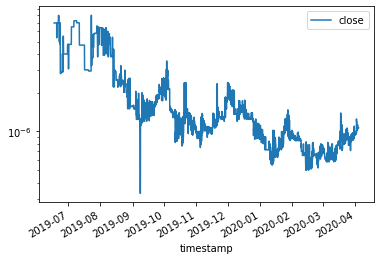

In [259]:
df[500:].plot(y='close', logy=True)

-------
## Training

In [82]:
hist = df

In [108]:
clip_size = 3000

In [83]:
hist = hist[clip_size:]

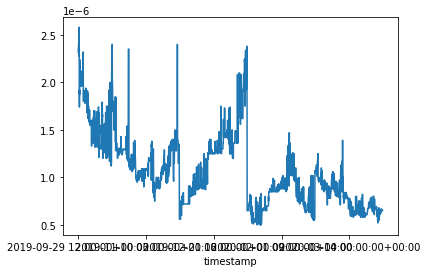

In [84]:
hist['close'].plot()

In [85]:
all_data = hist['close'].values.astype(float)

In [86]:
test_data_size = 100
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [87]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [88]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [89]:
train_window = 3
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [90]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [91]:
if torch.cuda.is_available():
        ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [92]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.ngpu = ngpu
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
model = LSTM(ngpu).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [93]:
epochs = 10
writer = SummaryWriter()
iters = 0
for i in tqdm(range(epochs)):
    for seq, labels in tqdm(train_inout_seq):
        seq = seq.to(device) 
        labels = labels.to(device)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        iters+=1
        writer.add_scalar("Loss", single_loss.item(), iters)
        


In [102]:
fut_pred = 6

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.817307710647583, -0.817307710647583, -0.817307710647583]


In [103]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())
test_inputs[fut_pred:]

[-1.0019478797912598, -1.0081028938293457, -1.0115854740142822]

In [104]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[6.02167015e-07]
 [5.38745003e-07]
 [5.10323310e-07]
 [4.97974205e-07]
 [4.91572990e-07]
 [4.87951107e-07]]


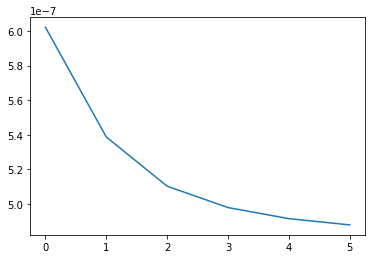

In [105]:
plt.plot(actual_predictions)

In [127]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

In [129]:
hist.index = pd.to_datetime(hist.index)

/home/collin/.virtualenvs/safex_trading_bot/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


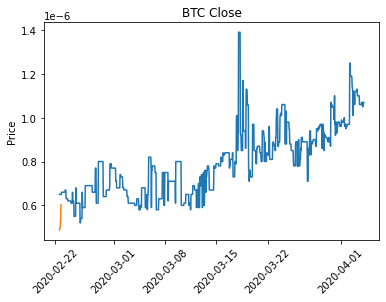

In [133]:
plt.title('BTC Close')
plt.ylabel('Price')
plt.plot(hist['close'][len(hist)-1000:len(hist)])
plt.plot(hist.index[len(hist)-6:len(hist)],actual_predictions)
ax = plt.axes()
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
plt.xticks(rotation=45)
plt.show()